

## BBC News Classification

Import libraries.

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt # for the pie chart

Start by reading the files.

In [5]:
y_train_data = pd.read_csv('y_train.csv', header=None, names=["class"])
x_train_data = pd.read_csv('X_train.csv', sep=' ')

y_test_data = pd.read_csv('y_test.csv', header=None, names=["class"])
x_test_data = pd.read_csv('X_test.csv', sep=' ')

x_train_values = x_train_data.values
y_train_values = y_train_data.values

x_test_values = x_test_data.values
y_test_values = y_test_data.values

Find the percentages for the classes in train data.

In [7]:
# Count the numbers of different types of news, find their percentage
class_counts0 = y_train_data['class'].value_counts()
class_percentages0 = (class_counts0 / len(y_train_data)) * 100
percentage_df0 = pd.DataFrame({'Percentage': class_percentages0})
print("Training Class Percentages")
print(percentage_df0)

Training Class Percentages
       Percentage
class            
3       22.601918
0       22.482014
2       19.124700
4       18.764988
1       17.026379


Let's implement the same procedure for the "y_test.csv" file as requested.

In [9]:
# Count the numbers of different types of news, find their percentage
class_counts1 = y_test_data['class'].value_counts()
class_percentages1 = (class_counts1 / len(y_test_data)) * 100
percentage_df1 = pd.DataFrame({'Percentage': class_percentages1})
print("Test Class Percentages")
print(percentage_df1)

Test Class Percentages
       Percentage
class            
0       24.236984
3       24.057451
1       18.312388
2       17.594255
4       15.798923


Pie charts of percentages.

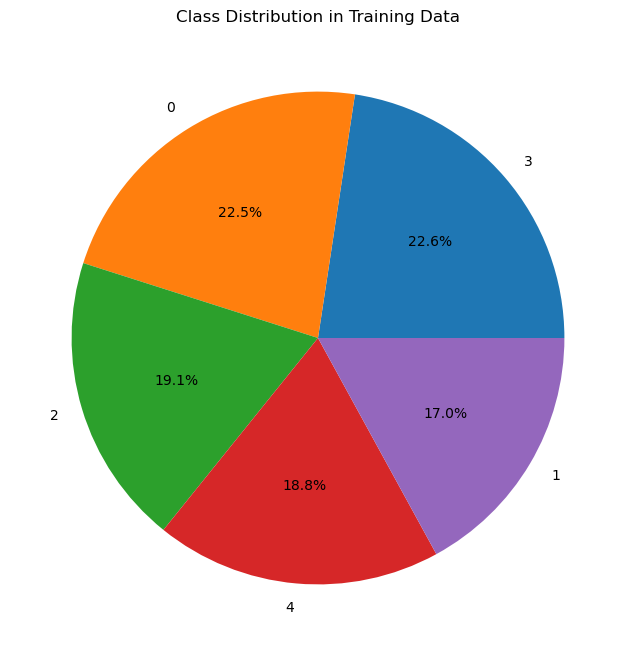

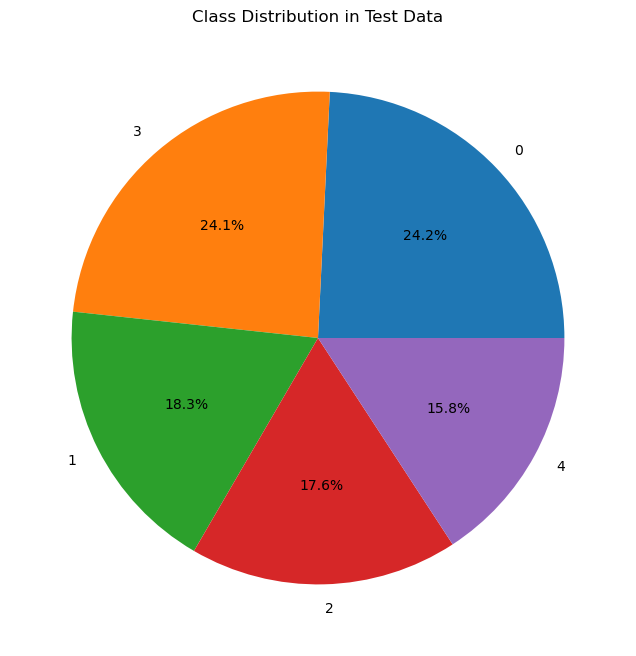

In [11]:
plt.figure(figsize=(8, 8))
plt.pie(class_counts0, labels=class_counts0.index, autopct='%1.1f%%')
plt.title('Class Distribution in Training Data')
plt.show()

plt.figure(figsize=(8, 8))
plt.pie(class_counts1, labels=class_counts1.index, autopct='%1.1f%%')
plt.title('Class Distribution in Test Data')
plt.show()

The probabilities of the classes are the same with their percentages. The probabilities of out 1 of training data can also be seen in the Multinomial Naive Bayes implementation.  

Merge x and y files for easier use. Find the number of the times the words ”alien” appears in the training documents with the label
”Tech”, including multiple occurrences.

In [14]:
train_data = pd.merge(x_train_data, y_train_data, left_index=True, right_index=True)

test_data = pd.merge(x_test_data, y_test_data, left_index=True, right_index=True)

tech_data = train_data[train_data["class_y"] == 4]

total_alien = tech_data["alien"].sum()

documents_with_alien = (tech_data["alien"] > 0).sum()

print("Total no of alien:", total_alien)
print("Number of documents with alien more than 0:", documents_with_alien)

Total no of alien: 3
Number of documents with alien more than 0: 3


Do the same for the word "thunder".

In [16]:
total_thunder = tech_data["thunder"].sum()

documents_with_thunder = (tech_data["thunder"] > 0).sum()

print("Total no of thunder:", total_thunder)
print("Number of documents with alien more than 0:", documents_with_thunder)

Total no of thunder: 0
Number of documents with alien more than 0: 0


What is the log ratio of their occurrences within those
documents, i.e, ln(P(alien | Y = Tech)) and ln(P(thunder | Y = Tech))

In [18]:
total_tech_doc = (y_train_data["class"] == 4).sum()

# Prob of alien
alien_prob = documents_with_alien / total_tech_doc
print("P(alien|Y=Tech):", alien_prob)

# Prob of thunder
thunder_prob = documents_with_thunder / total_tech_doc
print("P(thunder|Y=Tech):", thunder_prob)

# Logs
logPalien = np.log(alien_prob)
logPthunder = np.log(thunder_prob)

print("ln(P(alien|Y=Tech)):", logPalien)
print("ln(P(thunder|Y=Tech)):",logPthunder)

P(alien|Y=Tech): 0.009584664536741214
P(thunder|Y=Tech): 0.0
ln(P(alien|Y=Tech)): -4.647590901872044
ln(P(thunder|Y=Tech)): -inf


C:\Users\lenovo\AppData\Local\Temp\ipykernel_23080\3724732864.py:13: RuntimeWarning: divide by zero encountered in log
  logPthunder = np.log(thunder_prob)


## Multinomial Bayes Model

Now let's start with the implementation of the Multinomial Naive Bayes Model.

In [21]:
# Now lets find P(Y=newstype) values from that data, priors
class_counts = np.bincount(y_train_data["class"])
class_priors = (class_counts / len(y_train_data))

# Take ln values for the probabilities
ln_class_priors = np.log(class_priors)

In [22]:
y_train_values_flattened = y_train_data.values.flatten()

# Calculate likelihoods
word_counts_per_class = np.zeros((len(np.unique(y_train_values_flattened)), x_train_values.shape[1]))

for i in range(len(np.unique(y_train_values_flattened))):
  class_mask = (y_train_values_flattened == i)
  word_counts_per_class[i, :] = np.sum(x_train_values[class_mask, :], axis=0)

class_sums = np.sum(word_counts_per_class, axis=1)

word_likelihoods = word_counts_per_class / class_sums[:, np.newaxis]

In [23]:
y_test_values_flattened = y_test_values.flatten()

log_likelihoods = np.dot(np.log(word_likelihoods), x_test_values.T)

# Add priors to the log likelihoods

log_likelihoods += ln_class_priors.reshape(-1, 1)

# Predict the class with the highest log likelihood

predictions = np.argmax(log_likelihoods, axis=0)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_23080\3800583237.py:3: RuntimeWarning: divide by zero encountered in log
  log_likelihoods = np.dot(np.log(word_likelihoods), x_test_values.T)


In [24]:
# Created functions for accuracy and confusion matrix since they will be used later multiple times
def accuracy(y_pred, y_true):
    return np.mean(y_true == y_pred)

def get_conf_matrix(y_pred, y_true, num_classes):
    conf_matrix = np.zeros((num_classes, num_classes))
    for true in range(num_classes):
        for pred in range(num_classes):
            conf_matrix[true, pred] = np.sum((y_true == true) & (y_pred == pred))

    return conf_matrix

acc_mnb = accuracy(y_test_values_flattened, predictions)

print("Multinomial Naive Bayes Model Without Smoothing")
print(f"Accuracy of Model: {acc_mnb:.3f}")
conf_matrix = get_conf_matrix( predictions, y_test_values_flattened, num_classes=5)

print("Confusion Matrix:")
print(conf_matrix)

Multinomial Naive Bayes Model Without Smoothing
Accuracy of Model: 0.242
Confusion Matrix:
[[135.   0.   0.   0.   0.]
 [102.   0.   0.   0.   0.]
 [ 98.   0.   0.   0.   0.]
 [134.   0.   0.   0.   0.]
 [ 88.   0.   0.   0.   0.]]


## Multinomial Bayes with Smoothing


We are going to change the theta equation accordingly.

In [27]:
# a is the parameter for the Dirichlet Prior
a = 1;

word_likelihoods_sm = (word_counts_per_class + a) / (class_sums[:, np.newaxis] + (x_train_data.shape[1] * a ))

log_likelihoods_sm = np.dot(np.log(word_likelihoods_sm), x_test_values.T)

log_likelihoods_sm += ln_class_priors.reshape(-1, 1)

# Prediction
predictions_sm = np.argmax(log_likelihoods_sm, axis=0)

In [28]:
acc_sm = accuracy(y_test_values_flattened, predictions_sm)

print("Multinomial Naive Bayes Model With Smoothing")
print(f"Accuracy of Model: {acc_sm:.3f}")

conf_matrix_sm = get_conf_matrix(predictions_sm, y_test_values_flattened, num_classes=5)

# Confusion Matrix
print("Confusion Matrix:")
print(conf_matrix_sm)

Multinomial Naive Bayes Model With Smoothing
Accuracy of Model: 0.977
Confusion Matrix:
[[131.   0.   2.   0.   2.]
 [  0.  97.   0.   0.   5.]
 [  1.   0.  96.   0.   1.]
 [  0.   0.   1. 133.   0.]
 [  1.   0.   0.   0.  87.]]


## Bernoulli Naive Bayes Model

In [30]:
# Feature matrix to binary version
x_train_values_binary = (x_train_values > 0).astype(int)
x_test_values_binary = (x_test_values > 0).astype(int)

# Calculate Bernoulli likelihoods
word_occurrence_per_class = np.zeros((len(np.unique(y_train_values_flattened)), x_train_values.shape[1]))

for i in range(len(np.unique(y_train_values_flattened))):
    class_mask_ber = (y_train_values_flattened == i)
    word_occurrence_per_class[i, :] = np.sum(x_train_values_binary[class_mask_ber, :], axis=0)

class_sums_ber = np.sum(word_occurrence_per_class, axis=1)

alpha = 1
word_likelihoods_ber = (word_occurrence_per_class + alpha) / (class_sums_ber[:, np.newaxis] + 2 * alpha)

log_likelihoods_ber = np.dot(np.log(word_likelihoods_ber), x_test_values_binary.T)

log_likelihoods_ber += ln_class_priors.reshape(-1, 1)

predictions_ber = np.argmax(log_likelihoods_ber, axis=0)

Report the accuracy and confusion matrix for the model.

In [32]:
acc_ber = accuracy(y_test_values_flattened, predictions_ber)

print("Multinomial Naive Bayes Model With Smoothing")
print(f"Accuracy of Model: {acc_ber:.3f}")

conf_matrix_ber = get_conf_matrix( predictions_ber, y_test_values_flattened, num_classes=5)

print("Confusion Matrix:")
print(conf_matrix_ber)

Multinomial Naive Bayes Model With Smoothing
Accuracy of Model: 0.971
Confusion Matrix:
[[131.   1.   1.   0.   2.]
 [  0.  95.   1.   0.   6.]
 [  2.   0.  96.   0.   0.]
 [  0.   0.   1. 133.   0.]
 [  1.   1.   0.   0.  86.]]
